# Understanding the in-situ Solar Wind Properties with Machine Learning and Artificial Intelligence

## Clustering Models with the ACE Mission Data

NOTE: This notebook uses the "ACE Mission Cleaned.csv". Please refer to the <a href="../src/01_ACE_Mission_EDA.ipynb"> ACE EDA</a> notebook prior to using this notebook for dataset details and for the CSV file. 

<u><b>Objective:</u></b> <p>Use K-means clustering models to highlight features within the ACE Mission dataset that could be used for pattern recognition when combined in the HCS index data. Due to the limited data available from the HCS index collection, we hope to find additional features that may assist forecast models in accurately predicting HCS variables SD and SL (please refer to the <a href="../src/04_HCS_Sunspots_Reading_EDA.ipynb"> HCS Sunspots Reading </a> notebook for variable details). 

In [1]:
import numpy as np
import pandas as pd
import re
import altair as alt
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.options.display.max_columns = None

random_state = 4

First we will import the cleaned ACE dataset. For clustering purposes we will not need the "fp year" and "fp day" features. 

In [2]:
# read in data
# fp year and fp day are unnecessary for clustering
df = pd.read_csv("../data/ACE Mission Cleaned.csv").iloc[:, 2:]
df.head()

,proton_density,proton_temp,He4toprotons,proton_speed
0,16.655,9529.1,0.0127,323.90
1,20.601,8757.7,0.0141,322.89
2,18.679,9559.4,0.0087,324.61
3,18.481,8965.9,0.0051,322.68
4,28.315,8329.0,0.0061,321.84


Since our four variables have signficantly different scales we will scale the data using Standard Scaler to prevent variables in higher scales from over influencing clusters. 

In [3]:
# scale the data using standard scaler
scaled_df = StandardScaler().fit_transform(df)

In order to find the appropriate number of clusters for our K-means model, we will utilize the Davies-Bouldin and Calinski-Harabasz indexes. <p><b>The Davies-Bouldin Index (DBI)</b> calculates the ratio of inter-cluster and instra-cluster distances of each cluster with the cluster most similar to it providing an average score at the end. The lower the DBI score, the stronger the clusters. <p><b> The Calinski-Harabasz Index (CHI)</b> measures cluster cohesion (distance between centroid and data points) and separation (distance between centroid and global centroid). The higher the CHI, the stronger the clusters. <p>The function below will take in the ACE dataset and iterate through different cluster amounts to return a score dataframe showing DBI and CHI scores at each cluster amount. 



In [4]:
def cluster_scores(df: pd.DataFrame):

    # what are the optimal number of clusters?

    # find the calinski and davies scores of different numbers of kmeans clusters

    # optimal cluster numbers will have a high Calinski and a low Davies score

    cluster = []

    calinski = []

    davies = []

    for k in range(2, 10):

        kmeans = KMeans(
            n_clusters=k,
            init="k-means++",
            max_iter=100,
            n_init=1,
            random_state=random_state,
        ).fit(df)

        labels = kmeans.labels_

        cluster.append(k)

        calinski.append(metrics.calinski_harabasz_score(df, labels))

        davies.append(davies_bouldin_score(df, labels))

    score_df = pd.DataFrame(
        {"num_cluster": cluster, "calinski": calinski, "davies": davies}
    )
    return score_df

In [5]:
cluster_scores = cluster_scores(scaled_df)
cluster_scores

,num_cluster,calinski,davies
0,2,57797.596012,1.106740
1,3,49242.224949,1.104847
2,4,50798.331002,1.054070
3,5,47491.660015,1.094343
4,6,46585.772638,1.124053
5,7,43948.491179,1.137292
6,8,40886.714765,1.191542
7,9,41326.574760,1.162049


Next we will plot DBI and HCI and find the minimum and peak scores at cluster amounts. 

Text(0.5, 0.98, 'Scoring to Determine Optimal Number of Clusters \n Looking for clusters that have a low Davies-Bouldin score but a high Calinski-Harabasz score')

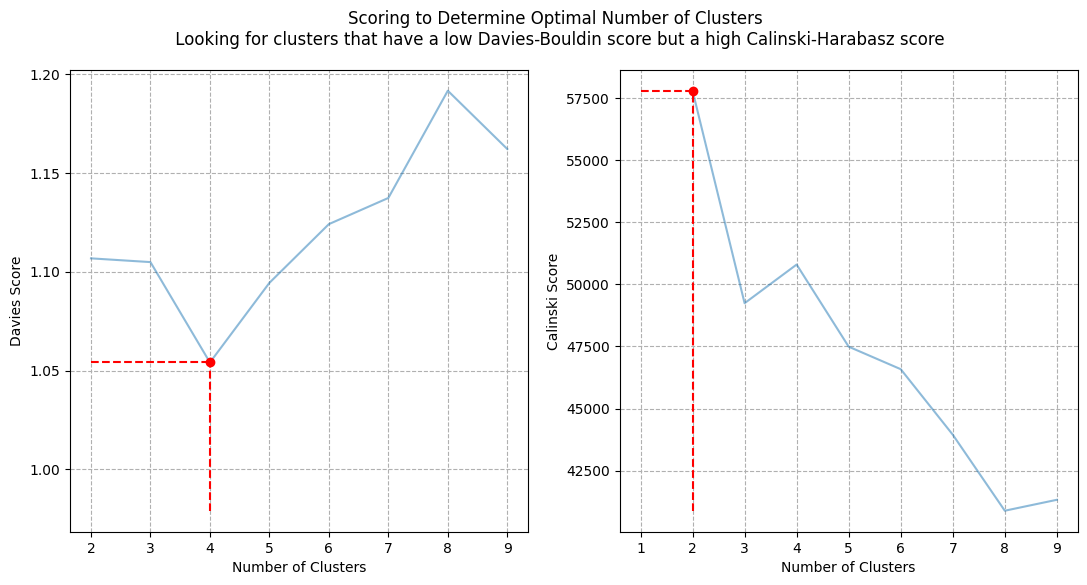

In [6]:
# visualize the Calinski and Davies scores
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# find min DBI and max CHI for annotation
CHI_score = cluster_scores["calinski"].idxmax()
DBI_score = cluster_scores["davies"].idxmin()
min_x = cluster_scores["num_cluster"].min()
max_x = cluster_scores["num_cluster"].max()

# create y and k values for each index to plot annotation
CHI_max_k = cluster_scores["num_cluster"].iloc[CHI_score]
CHI_max_y = cluster_scores["calinski"].iloc[CHI_score]
CHI_max_ys = [CHI_max_y] * len([min_x, CHI_max_y])
CHI_max_ks = [CHI_max_k] * 2
CHI_min_y = cluster_scores["calinski"].min()

DBI_max_k = cluster_scores["num_cluster"].iloc[DBI_score]
DBI_max_y = cluster_scores["davies"].iloc[DBI_score]
DBI_max_ys = [DBI_max_y] * len([min_x, DBI_max_y])
DBI_max_ks = [DBI_max_k] * 2
DBI_min_y = (
    cluster_scores["davies"].min() - 0.075
)  # slight adjustment for greater annotation since we are finding a minimum.


ax1.plot(cluster_scores["num_cluster"], cluster_scores["davies"], alpha=0.5)
ax1.plot([min_x, DBI_max_k], DBI_max_ys, linestyle="--", c="red")
ax1.plot(DBI_max_k, DBI_max_y, marker="o", c="red")
ax1.plot(DBI_max_ks, [DBI_min_y, DBI_max_y], linestyle="--", c="red")
ax1.set_ylabel("Davies Score")
ax1.set_xlabel("Number of Clusters")
ax1.yaxis.grid(ls="--")
ax1.xaxis.grid(ls="--")
# ax1.set_xlim([min_x-.5, max_x])
# ax1.set_ylim([DBI_min_y, DBI_max_y])

ax2.plot(cluster_scores["num_cluster"], cluster_scores["calinski"], alpha=0.5)
ax2.plot([min_x - 1, CHI_max_k], CHI_max_ys, linestyle="--", c="red")
ax2.plot(CHI_max_k, CHI_max_y, marker="o", c="red")
ax2.plot(CHI_max_ks, [(CHI_min_y), CHI_max_y], linestyle="--", c="red")
ax2.set_ylabel("Calinski Score")
ax2.set_xlabel("Number of Clusters")
ax2.yaxis.grid(ls="--")
ax2.xaxis.grid(ls="--")
# ax2.set_xlim([min_x, max_x])
# ax2.set_ylim([CHI_min_y, CHI_max_y])


fig.suptitle(
    "Scoring to Determine Optimal Number of Clusters \n Looking for clusters that have a low Davies-Bouldin score but a high Calinski-Harabasz score"
)

Above we notice CHI is highest at 2 clusters, but DBI is lowest at 4. We will utilize the Elbow Method to determine whether our number of clusters should be 2 or 4. <p>The Elbow Method takes the sum of squared distances (within-cluster sum of squares, WCSS) and plots them against k number of clusters. Over the visual, WCSS decreases until we notice a signficant change in slope. The k value where this slope change occurs is our ideal k value. <p> The function below will plot the Elbow Method.  

In [7]:
def k_method(df: pd.DataFrame):
    # an elbow plot can also be used to look for the optimal number of clusters

    sum_of_squared_distances = []

    K = range(2, 10)

    for k in K:

        k_means = KMeans(n_clusters=k, init="k-means++", n_init=1)
        model = k_means.fit(df)

        sum_of_squared_distances.append(k_means.inertia_)

    plt.plot(K, sum_of_squared_distances)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Distances")
    plt.title("Elbow Method for Optimal K")

    return plt.show()

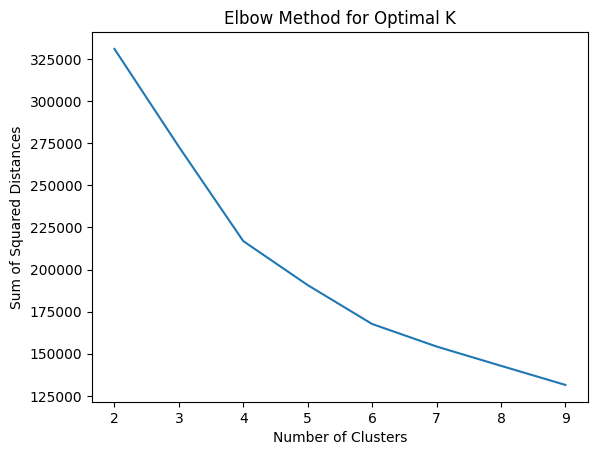

In [8]:
k_method(scaled_df)

The Elbow Method in conjunction with DBI confirms that 4 clusters should be our k value for the K-Means model. <p>Below we will create a K-means model using 4 clusters. 

In [9]:
optimal_k = 4  # appears to be optimal after comparing the Davies scores, Calinski scores, and the elbow plot

# build a kmeans model using the optimal number of clusters
kmeans = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    max_iter=100,
    n_init=1,
    random_state=random_state,
).fit(scaled_df)

Using our K-means model we will compare centroids for each feature within each cluster. This will give us a preview of how similar each cluster is and whether specific features differ significantly between the clusters. <p>The function below will create a dataframe showing centroid values for each ACE feature along with a cluster prediction column. 

In [10]:
def pd_centers(cols_of_interest: list, centers: kmeans.cluster_centers_, rand=vars):
    random_state = rand
    colNames = cols_of_interest.copy()
    colNames.append("prediction")
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P["prediction"] = P["prediction"].astype(int)
    return P

In [11]:
centers = kmeans.cluster_centers_
P = pd_centers(
    ["Proton Density", "Proton Temp", "He4toproton", "Speed"], centers, random_state
)
P  # these are the transformed values

,Proton Density,Proton Temp,He4toproton,Speed,prediction
0,-0.128559,-0.432876,-0.379012,-0.495972,0
1,2.564002,-0.452186,-0.166791,-0.701001,1
2,-0.423408,1.271149,-0.174936,1.323906,2
3,-0.115371,-0.493274,1.554561,-0.263480,3


Now let's plot the centroids to preview the clusters. 

In [12]:
Pcenters = pd.melt(P, id_vars=["prediction"], var_name="var", value_name="val")
Pcenters["prediction"] = Pcenters["prediction"].astype(str)
fig = px.scatter(
    Pcenters,
    x="val",
    y="prediction",
    color="var",
    labels=dict(val="Value", var="Features", prediction="Predicted Cluster"),
    title="K-Means Clustering of Solar Winds",
)
fig.update_layout(
    plot_bgcolor="white",
    autosize=False,
    width=900,
    height=500,
    title={"x": 0.5, "xanchor": "center", "y": 0.875},
)
fig.update_xaxes(
    mirror=True,
    ticks="outside",
    showline=True,
    linecolor="black",
    zerolinecolor="black",
    zerolinewidth=0.25,
    gridcolor="lightgrey",
)
fig.update_yaxes(
    mirror=True,
    ticks="outside",
    showline=True,
    linecolor="black",
    zerolinecolor="black",
    gridcolor="lightgrey",
)
fig.update_traces(marker=dict(size=12))

Centroids for each feature appear to be very close in value for each cluster with cluster 0 keeping all features close together. To further visualize clusters we will plot on a 2D plane iterating through the feature combinations to see if any features can highlight the most distinct clusters.  <p> The following function will create a new dataframe combining the original ACE data with the cluster labels provided by K-means. 

In [13]:
def ace_cluster_df(df: pd.DataFrame, labels: np.array):
    df2 = df.copy()
    df2["Cluster"] = labels

    return df2

In [14]:
ace_cluster_df = ace_cluster_df(df, kmeans.labels_)
ace_cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121969 entries, 0 to 121968
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   proton_density  121969 non-null  float64
 1   proton_temp     121969 non-null  float64
 2   He4toprotons    121969 non-null  float64
 3   proton_speed    121969 non-null  float64
 4   Cluster         121969 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 4.2 MB


With our new cluster dataframe we'll plot each feature pair and review the clusters. 

Text(0, 0.5, 'Speed')

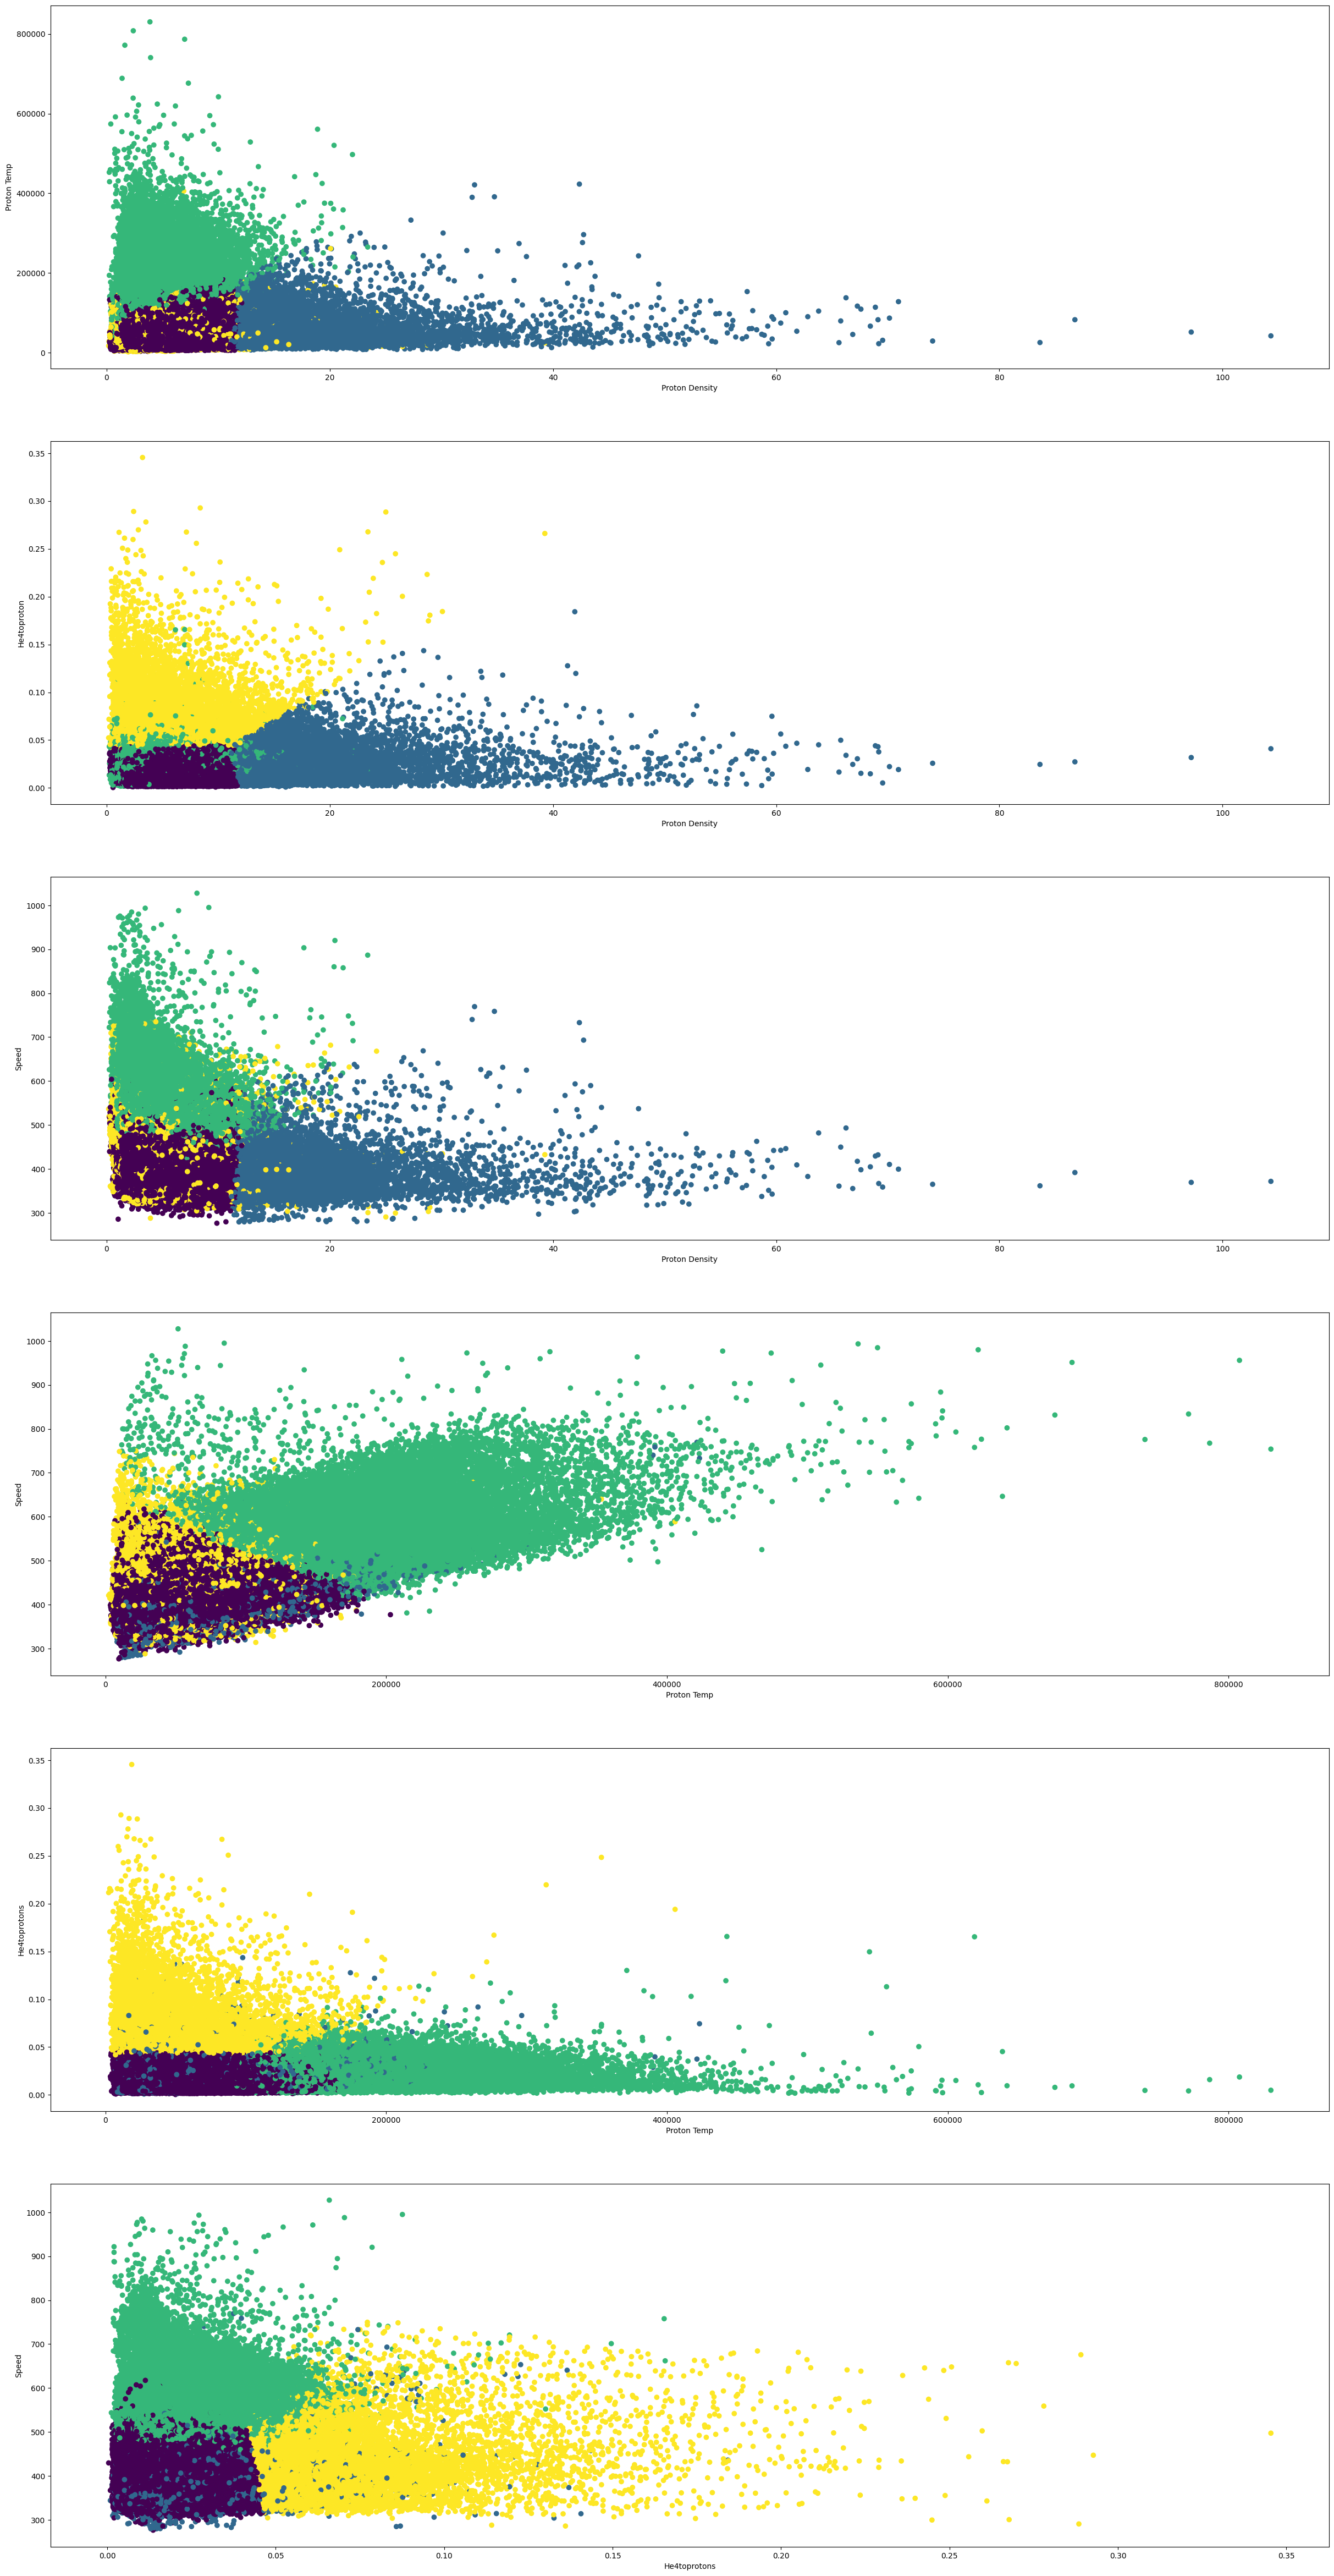

In [15]:
fig, axs = plt.subplots(6, 1, figsize=(30, 60))

axs[0].scatter(
    ace_cluster_df["proton_density"],
    ace_cluster_df["proton_temp"],
    c=ace_cluster_df["Cluster"],
)
axs[0].set_xlabel("Proton Density")
axs[0].set_ylabel("Proton Temp")
axs[1].scatter(
    ace_cluster_df["proton_density"],
    ace_cluster_df["He4toprotons"],
    c=ace_cluster_df["Cluster"],
)
axs[1].set_xlabel("Proton Density")
axs[1].set_ylabel("He4toproton")
axs[2].scatter(
    ace_cluster_df["proton_density"],
    ace_cluster_df["proton_speed"],
    c=ace_cluster_df["Cluster"],
)
axs[2].set_xlabel("Proton Density")
axs[2].set_ylabel("Speed")
axs[3].scatter(
    ace_cluster_df["proton_temp"],
    ace_cluster_df["proton_speed"],
    c=ace_cluster_df["Cluster"],
)
axs[3].set_xlabel("Proton Temp")
axs[3].set_ylabel("Speed")
axs[4].scatter(
    ace_cluster_df["proton_temp"],
    ace_cluster_df["He4toprotons"],
    c=ace_cluster_df["Cluster"],
)
axs[4].set_xlabel("Proton Temp")
axs[4].set_ylabel("He4toprotons")
axs[5].scatter(
    ace_cluster_df["He4toprotons"],
    ace_cluster_df["proton_speed"],
    c=ace_cluster_df["Cluster"],
)
axs[5].set_xlabel("He4toprotons")
axs[5].set_ylabel("Speed")

Unfortunately the clusters are very close together. Let's visualize some feature combinations on a 3D plane to see if clusters are more defined. Based on the 2D plots we'll focus on Proton Temp, He4toprotons, and Proton Density. 

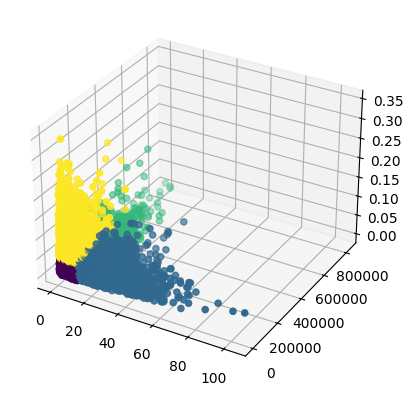

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x = np.array(ace_cluster_df["proton_density"])
y = np.array(ace_cluster_df["proton_temp"])
z = np.array(ace_cluster_df["He4toprotons"])

ax.scatter(x, y, z, c=ace_cluster_df["Cluster"])
plt.show()

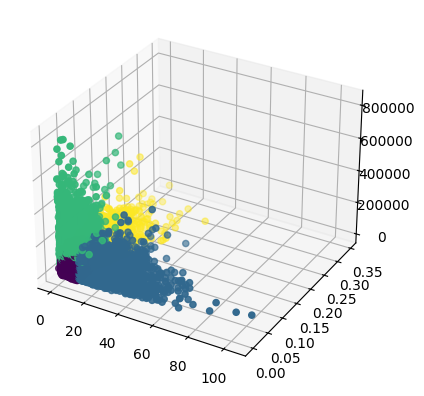

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

x = np.array(ace_cluster_df["proton_density"])
y = np.array(ace_cluster_df["He4toprotons"])
z = np.array(ace_cluster_df["proton_temp"])

ax.scatter(x, y, z, c=ace_cluster_df["Cluster"])
plt.show()

K-means does not result in distinct enough clusters when utilizing the features from ACE data. <p>Next we will use Principle Component Analysis (PCA) to enhance our K-means model and see if clusters become more defined. Before using PCA we need to understand how many components we would like PCA to create from our data. In order to do this we will review the cumulative explained variance. Plotted against the number of principal components we can see how much variance results in the dataset when using a specific number of components. Our goal will be to reach as close to 80% variance without going over. <p> The following function will take in our scaled ACE data and plot the cumulative explained variance.  

In [18]:
def evaluate_PCA_components(features: list, X):
    from sklearn.decomposition import PCA

    pca = PCA()

    pca.fit(X)

    num_components = list(range(1, len(features) + 1))

    plt.figure(figsize=(10, 10))
    plt.plot(
        num_components,
        pca.explained_variance_ratio_.cumsum(),
        marker="o",
        linestyle="--",
    )
    plt.title("Variance Ratio by Number of Components")
    plt.xlabel("# of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(ls="--")

    return plt.show()

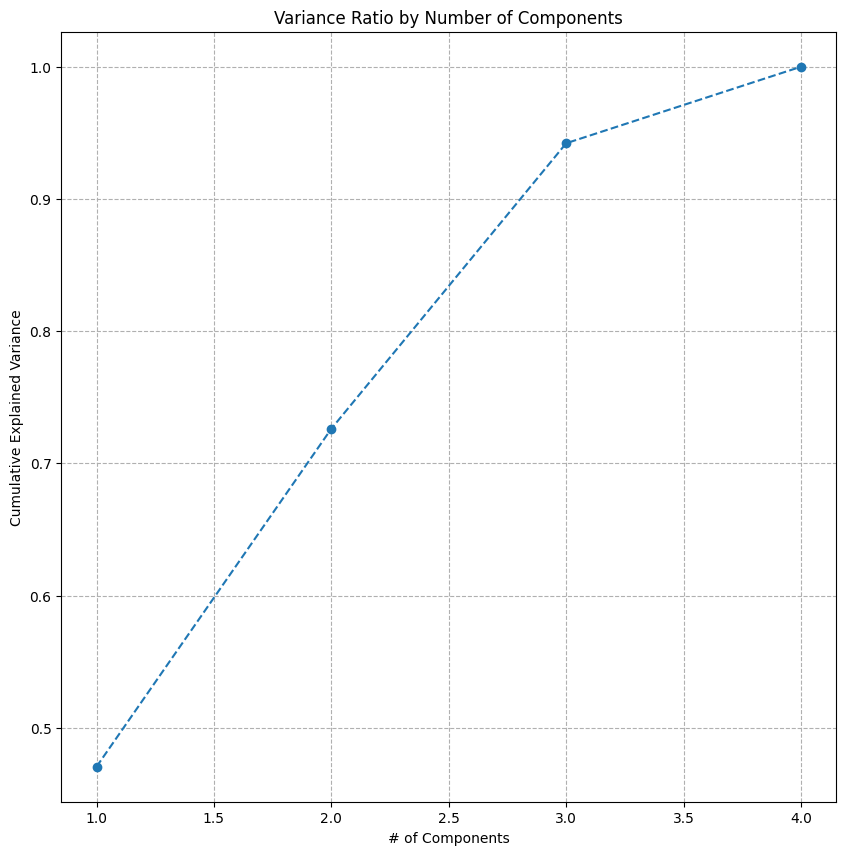

In [19]:
# list of features from the original unscaled data
feats = df.columns.tolist()

evaluate_PCA_components(feats, scaled_df)

According to the plot we should use 2 components for PCA. We'll use PCA to create 2 principal components from the ACE data. 

In [20]:
pca = PCA(n_components=2)
pca.fit(scaled_df)

pca_df = pca.transform(scaled_df)

kmeans_pca = KMeans(
    n_clusters=optimal_k,
    init="k-means++",
    max_iter=100,
    n_init=1,
    random_state=random_state,
)

kmeans_pca.fit(pca_df)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=4)

Now let's have a quick look at CHI and DBI. 

In [21]:
print(
    metrics.calinski_harabasz_score(pca_df, kmeans_pca.labels_),
    davies_bouldin_score(pca_df, kmeans_pca.labels_),
)

86742.12451848891 0.9060390745368205


Both DBI and CHI improved when compared to K-means without PCA. Let's combine create a dataframe from our PCA components and cluster labels. We'll combine this with the cleaned ACE Mission data at the end to be used with HCS forecasting. 

In [22]:
# create pca dataframe
pca_df = pd.DataFrame(pca_df, columns=["PC1", "PC2"])
pca_df["Cluster"] = kmeans_pca.labels_

Now we'll plot the PCA dataset to review the clusters. 


Text(0.5, 1.0, 'PCA Enhanced K-means Clusters')

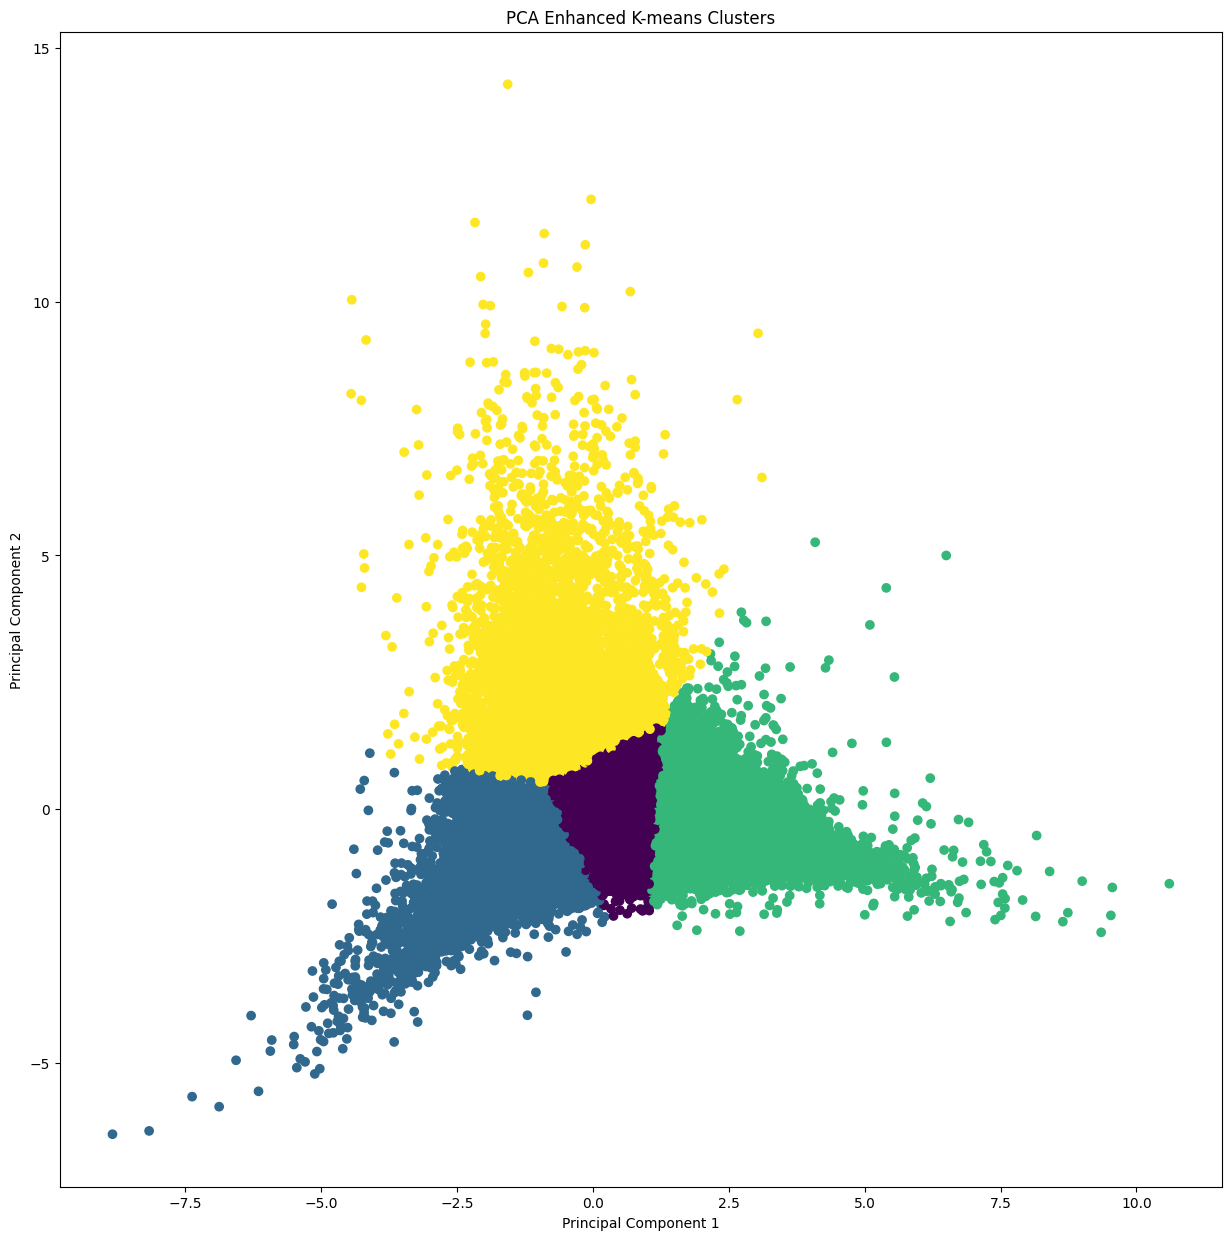

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"])
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("PCA Enhanced K-means Clusters")

Clusters are still close together, but the decision boundary is much more defined than what we've seen previously. <p> Let's combine the PCA dataframe with the ACE Mission data and create a CSV to be used for the HCS index model. For this purpose we will not need the cluster labels and will withhold them from the join.  

In [24]:
# import ACE mission data with fp year and fp day.
ACE_df = pd.read_csv("../data/ACE Mission Cleaned.csv")

ACE_Mission_PCA_df = pd.concat([ACE_df, pca_df.iloc[:, :2]], axis=1)
ACE_Mission_PCA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121969 entries, 0 to 121968
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fp_year         121969 non-null  float64
 1   fp_doy          121969 non-null  float64
 2   proton_density  121969 non-null  float64
 3   proton_temp     121969 non-null  float64
 4   He4toprotons    121969 non-null  float64
 5   proton_speed    121969 non-null  float64
 6   PC1             121969 non-null  float64
 7   PC2             121969 non-null  float64
dtypes: float64(8)
memory usage: 7.4 MB


In [25]:
def create_csv(df, filename):
    # creates file under assets folder in same directory as notebook
    return df.to_csv(
        r"../data/" + filename,
        index=False,
    )

In [26]:
create_csv(ACE_Mission_PCA_df, "ACE_Mission_PCA.csv")

We have a 2 principal components to add to our HCS model. Please refer to the <a href="../src/04_HCS_Sunspots_Reading_EDA.ipynb"> HCS Sunspots Reading </a> notebook for implementation. <p> Please refer to the <a href="../src/03_ACE_Mission_DBSCAN.ipynb"> DBSCAN </a> notebook for DBSCAN clustering with the ACE Mission dataset. 